In [801]:
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
from matplotlib import path
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime, timedelta
from matplotlib import gridspec as gds
from minepy import MINE
import netCDF4 as nc
import os

In [ ]:
with plt.xkcd():
    

In [802]:
# общий массив данных
meteo = pd.DataFrame()

# цикл по годам
for year in range(2015,2023):
    # открываем метеоданные
    m = pd.read_csv(f'/Users/ilyadrozd/Desktop/IO/meteo/meteo_{year}.csv', sep=' ', header=None, 
                        names=['datetime', 'lat','lon','u10', 'v10', 'sst', 't2m', 'd2m', 'msl', 'lhf', 'shf', 'srd', 'trd', 'lsm'])

    # открываем потоки по времени и координатам
    fluxes = pd.read_csv(f'/Users/ilyadrozd/Desktop/IO/meteo/fluxes_coare3p6_{year}.csv', sep=' ', header=None, skipinitialspace=True,
                        names=['datetime', 'lat','lon','LE', 'H', 'tau_x', 'tau_y'])

    # мерджим потоки и метеоданные
    m = pd.merge(m, fluxes, on=['datetime', 'lat', 'lon'])

    # примерно вырезаем интересующий нас участок по широте и долготе
    m = m.loc[(m['lat']>-64.75)&(m['lat']<-61.25)]
    m = m.loc[(m['lon']>-63)&(m['lon']<-54.75)]

    # убираем данные над сушей
    m.loc[m['lsm']>0.285, ['u10', 'v10', 'sst', 't2m', 'd2m', 'msl', 'lhf',
           'shf', 'srd', 'trd', 'LE', 'H', 'tau_x', 'tau_y']] = np.nan

    # добавляем этот год к общему массиву данных
    meteo = pd.concat([meteo,m], ignore_index=True)
    
# переводим время в читаемый формат
meteo['datetime'] = pd.to_datetime(meteo['datetime'], origin='1900-01-01 00:00:00.0', unit='h')

# оставляем данные только за 12 часов
# meteo = meteo.loc[meteo['time'].dt.hour == 12]
# meteo['time'] = meteo['time'].dt.date

meteo

,datetime,lat,lon,u10,v10,sst,t2m,d2m,msl,lhf,shf,srd,trd,lsm,LE,H,tau_x,tau_y
0,2015-01-01 00:00:00,-61.5,-62.75,4.298785,3.059223,274.384505,273.910307,270.946073,101493.213673,-87509.066913,-7400.737796,3.201211e+05,1.028973e+06,0.0,-19.110601,-4.288819,0.028899,0.020566
1,2015-01-01 00:00:00,-61.5,-62.50,4.509805,3.115742,274.383533,273.893396,270.778307,101483.400813,-92880.146369,-8229.152458,3.312748e+05,1.018929e+06,0.0,-20.680037,-4.583673,0.031831,0.021992
2,2015-01-01 00:00:00,-61.5,-62.25,4.704399,3.140315,274.366911,273.867692,270.705973,101472.455701,-92440.694414,-7852.600339,3.492004e+05,1.005747e+06,0.0,-21.534536,-4.796482,0.034581,0.023084
3,2015-01-01 00:00:00,-61.5,-62.00,4.845922,3.148301,274.361078,273.861604,270.649444,101462.894453,-93905.534265,-7074.392627,3.596570e+05,9.897770e+05,0.0,-22.210591,-4.885339,0.036628,0.023796
4,2015-01-01 00:00:00,-61.5,-61.75,4.988709,3.139086,274.365939,273.854163,270.586835,101453.459011,-91724.550486,-6371.495338,3.728024e+05,9.720873e+05,0.0,-23.000727,-5.095606,0.038738,0.024376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013435,2022-12-31 18:00:00,-64.5,-56.00,2.090421,-3.815788,272.985811,273.452157,271.137536,98766.882503,-30002.059710,12104.158409,2.901239e+06,7.915775e+05,0.0,-6.524666,3.101401,0.009032,-0.016487
2013436,2022-12-31 18:00:00,-64.5,-55.75,2.731786,-4.092157,273.057137,273.461807,271.008491,98777.650170,-39544.543497,13265.399005,2.885493e+06,7.999036e+05,0.0,-8.603302,3.167410,0.014144,-0.021187
2013437,2022-12-31 18:00:00,-64.5,-55.50,3.177195,-4.353794,273.136281,273.524211,270.917008,98789.422818,-47999.005768,15241.978744,2.858622e+06,8.083152e+05,0.0,-10.563577,3.407869,0.018759,-0.025706
2013438,2022-12-31 18:00:00,-64.5,-55.25,3.426046,-4.602467,273.221208,273.641299,270.861876,98801.913312,-55472.465033,17984.483131,2.820376e+06,8.167636e+05,0.0,-12.076295,3.922606,0.022053,-0.029626


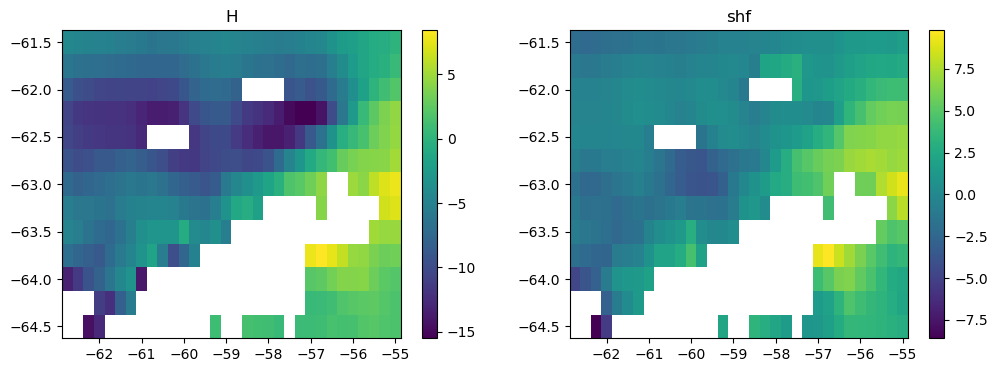

In [620]:
# Пример методанных
time = pd.Timestamp('2015-01-01')
val1 = 'H'
val2 = 'shf'

lat = np.arange(meteo.lat.max(), meteo.lat.min()-0.25, -0.25)
lon = np.arange(meteo.lon.min(), meteo.lon.max()+0.25, 0.25)

data = meteo.loc[meteo['datetime']==time][val1]
data = data.values.reshape(len(lat), len(lon))

plt.figure(figsize=(12,4))

ax1 = plt.subplot(121)
ax1.set_title(val1)
map1 = ax1.pcolormesh(lon, lat, data) #pcolormesh contourf
plt.colorbar(map1)


data = meteo.loc[meteo['datetime']==time][val2]
data = data.values.reshape(len(lat), len(lon))/3600

ax2 = plt.subplot(122, sharex=ax1)
ax2.set_title(val2)
map2 = ax2.pcolormesh(lon, lat, data) #pcolormesh contourf
plt.colorbar(map2)

In [849]:
# открываем данные по переносам
df = pd.read_csv(r'/Users/ilyadrozd/Desktop/IO/brans Q.txt')

# убираем лишние данные
BW = df[['Section','datetime','Bransfield lat','Bransfield lon','Bransfield positive flow rate',
         'Weddell lat','Weddell lon','Weddell negative flow rate']]

# переименновываем колонки df
BW.columns = ['section','time','lat_B','lon_B','flow_B','lat_W','lon_W','flow_W']

# задаем формат данных
BW = BW.astype({'lat_B':np.float64,'lon_B':np.float64,'flow_B':np.float64,'lat_W':np.float64,'lon_W':np.float64,'flow_W':np.float64})

# переводим время в формат даты и сортируем по времени
BW['time'] = pd.to_datetime(BW['time'])
BW.sort_values('time', inplace=True, ignore_index=True)

# округляем координаты и время переносов до разрешения реанализа
BW['lat_B_025'] = np.round(BW['lat_B']/0.25)*0.25
BW['lon_B_025'] = np.round(BW['lon_B']/0.25)*0.25
BW['lat_W_025'] = np.round(BW['lat_W']/0.25)*0.25
BW['lon_W_025'] = np.round(BW['lon_W']/0.25)*0.25

BW['time_6'] = pd.to_datetime(np.round(BW['time'].values.astype(np.float64)/(6*3.6e+12))*(6*3.6e+12))
BW = BW[2:]

BW['flow_B'] = BW['flow_B']/10**6
BW['flow_W'] = BW['flow_W']/10**6

BW.flow_B.loc[(BW.flow_B>3.4)|(BW.flow_B<0.7)] = np.nan
BW.flow_W.loc[(BW.flow_W>-0.1)|(BW.flow_W<-1.5)] = np.nan



/var/folders/9b/mz6gplyd4gb2ks60mcv4xhw00000gn/T/ipykernel_20639/1419688273.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BW.flow_B.loc[(BW.flow_B>3.4)|(BW.flow_B<0.7)] = np.nan
/var/folders/9b/mz6gplyd4gb2ks60mcv4xhw00000gn/T/ipykernel_20639/1419688273.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BW.flow_W.loc[(BW.flow_W>-0.1)|(BW.flow_W<-1.5)] = np.nan


In [850]:
BW.flow_W.min()

-1.4599750665476139

In [851]:
# функция для поворота векторов
def rotated(dig, u, v):
    rad = np.radians(dig) #угол наклона полигона относительно параллели в радианах
    u_rot=u*np.cos(rad)+v*np.sin(rad)
    v_rot=u*np.cos(rad+np.pi/2)+v*np.sin(rad+np.pi/2)
    return u_rot, v_rot

In [852]:
def compare(x, y, rnd=2):
    r = np.corrcoef(x, y)[0, 1]
    mine = MINE(alpha=0.6, c=15, est="mic_approx")
    mine.compute_score(x, y)
    mic = mine.mic()
    return round(r,rnd), round(mic,rnd)

In [853]:
window = 1
dig = 30


meteo['tau_x_rot'] = np.nan
meteo['tau_y_rot'] = np.nan

for flow, time, lat, lon in zip(BW.flow_B, BW.time_6, BW.lat_B_025, BW.lon_B_025):
    
    filt = (meteo.datetime==time) & (meteo.lat==lat) & (meteo.lon==lon)
    row = meteo.loc[filt]
    
    # отбрасываем непересекающиеся данные (например переносы за 2002 год) 
    if row.empty:
        continue
    
    # отбрасываем случаи, когда нет данных по ветру (данные попали под маску) или по переносу
    if np.isnan(flow) | np.isnan(row.tau_x.values[0]):
#         print(time, flow, row.tau_x.values[0])
        continue
    
    # считываем потоки импульса
    index = row.index[0]+1
    tau_x = meteo.tau_x.loc[index-window:index].mean()
    tau_y = meteo.tau_y.loc[index-window:index].mean()
    
    # поворачиваем потоки импульса вдоль пролива
    meteo.loc[filt, 'tau_x_rot'], meteo.loc[filt, 'tau_y_rot'] = rotated(dig, tau_x, tau_y)

B = pd.merge(BW[['time_6','lat_B_025','lon_B_025','flow_B']], meteo[['datetime','lat','lon','tau_x_rot','tau_y_rot']],
             left_on=['time_6','lat_B_025','lon_B_025'], right_on=['datetime','lat','lon'])
B = B[(B.flow_B.notna())&(B.tau_x_rot.notna())]


meteo['tau_x_rot'] = np.nan
meteo['tau_y_rot'] = np.nan

for flow, time, lat, lon in zip(BW.flow_W, BW.time_6, BW.lat_W_025, BW.lon_W_025):
    
    filt = (meteo.datetime==time) & (meteo.lat==lat) & (meteo.lon==lon)
    row = meteo.loc[filt]
    
    # отбрасываем непересекающиеся данные (например переносы за 2002 год) 
    if row.empty:
        continue
    
    # отбрасываем случаи, когда нет данных по ветру (данные попали под маску) или по переносу
    if np.isnan(flow) | np.isnan(row.tau_x.values[0]):
#         print(time, flow, row.tau_x.values[0])
        continue
    
    # считываем потоки импульса
    index = row.index[0]+1
    tau_x = meteo.tau_x.loc[index-window:index].mean()
    tau_y = meteo.tau_y.loc[index-window:index].mean()
    
    # поворачиваем потоки импульса вдоль пролива
    meteo.loc[filt, 'tau_x_rot'], meteo.loc[filt, 'tau_y_rot'] = rotated(dig, tau_x, tau_y)

W = pd.merge(BW[['time_6','lat_W_025','lon_W_025','flow_W']], meteo[['datetime','lat','lon','tau_x_rot','tau_y_rot']],
             left_on=['time_6','lat_W_025','lon_W_025'], right_on=['datetime','lat','lon'])
W = W[(W.flow_W.notna())&(W.tau_x_rot.notna())]




In [854]:
np.corrcoef(B.flow_B,B.tau_x_rot)

array([[ 1.        , -0.16702347],
       [-0.16702347,  1.        ]])

In [855]:

np.corrcoef(W.flow_W,W[W.tau_x_rot.notna()].tau_x_rot)

array([[1.        , 0.09520086],
       [0.09520086, 1.        ]])

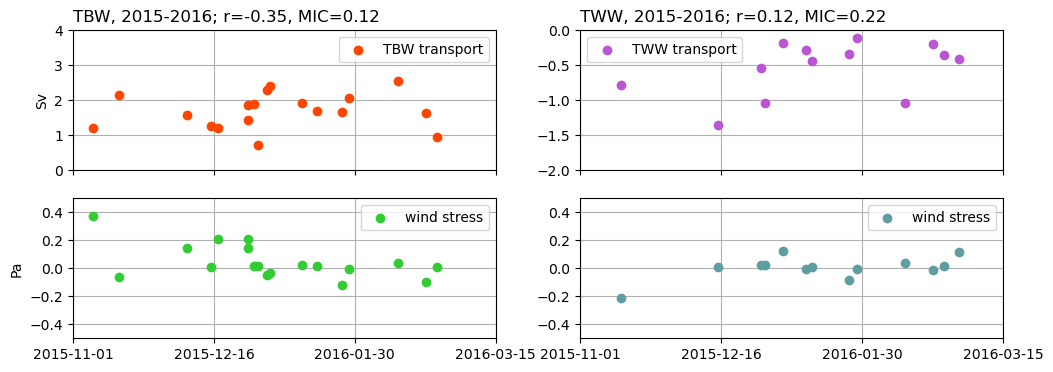

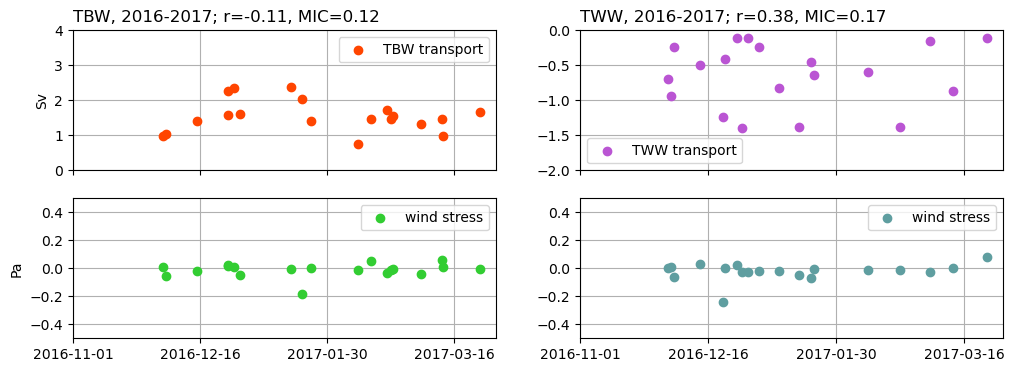

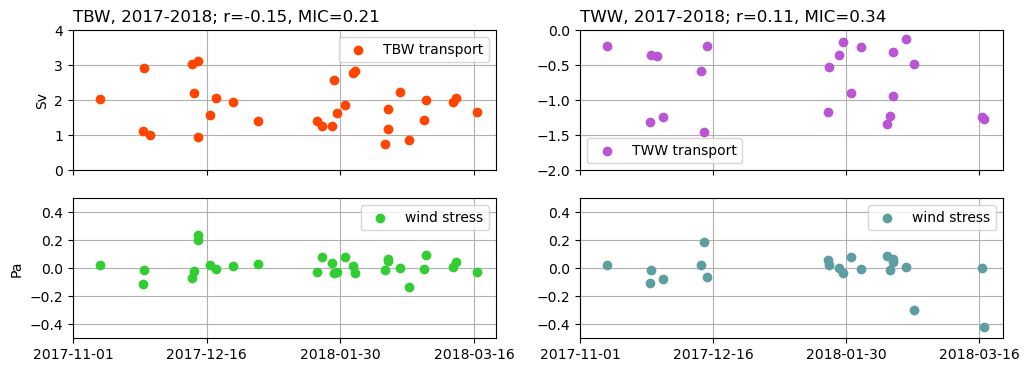

In [858]:
starts = pd.to_datetime(['2015-11-01 00:00:00','2016-11-01 00:00:00', '2017-11-01 00:00:00'])
ends = pd.to_datetime(['2016-04-01 00:00:00','2017-04-01 00:00:00', '2018-04-01 00:00:00'])

for start, end in zip(starts, ends):
    Bm = B.loc[(B.time_6>start)&(B.time_6<end)]
    B_r, B_mic =  compare(Bm.tau_x_rot, Bm.flow_B)
    
    Wm = W.loc[(W.time_6>start)&(W.time_6<end)]
    W_r, W_mic =  compare(Wm.tau_x_rot, Wm.flow_W)
    
    
    if end - start < np.timedelta64(14, 'D'):
        step = np.timedelta64(2, 'D')
    elif end - start < np.timedelta64(32, 'D'):
        step = np.timedelta64(10, 'D')
    else:
        step = np.timedelta64(45, 'D')
        
    
    plt.figure(figsize=(12,4))
    
    ax1 = plt.subplot(221)
    ax1.set_title(f'TBW, {start.year}-{end.year}; r={B_r}, MIC={B_mic}', loc='left')
    ax1.scatter(Bm.time_6, Bm.flow_B, label='TBW transport', c='orangered', zorder=2)
    ax1.set_xticks(np.arange(start, end, step, dtype='datetime64[s]'))
    ax1.set_xticklabels(labels=[])
    ax1.set_ylim([0,4])
    ax1.set_ylabel('Sv')
    ax1.legend()
    ax1.grid(zorder=1)
    
    ax2 = plt.subplot(222)
    ax2.set_title(f'TWW, {start.year}-{end.year}; r={W_r}, MIC={W_mic}', loc='left')
    ax2.scatter(Wm.time_6, Wm.flow_W, label='TWW transport', c='mediumorchid', zorder=2)
    ax2.set_xticks(np.arange(start, end, step, dtype='datetime64[s]'))
    ax2.set_xticklabels(labels=[])
    ax2.set_ylim([-2,0])
#     ax2.set_ylabel('Sv')
    ax2.legend()
    ax2.grid(zorder=1)
    
    ax3 = plt.subplot(223)
    ax3.scatter(Bm.time_6, Bm.tau_x_rot, label='wind stress', c='limegreen', zorder=2)
    ax3.set_xticks(np.arange(start, end, step, dtype='datetime64[s]'))
    ax3.set_ylim([-0.5,0.5])
    ax3.set_ylabel('Pa')
    ax3.legend()
    ax3.grid(zorder=1)
    
    ax4 = plt.subplot(224)
    ax4.scatter(Wm.time_6, Wm.tau_x_rot, label='wind stress', c='cadetblue', zorder=2)
    ax4.set_xticks(np.arange(start, end, step, dtype='datetime64[s]'))
    ax4.set_ylim([-0.5,0.5])
#     ax4.set_ylabel('Pa')
    ax4.legend()
    ax4.grid(zorder=1)
    
    plt.savefig(f'/Users/ilyadrozd/Desktop/IO/trans_wind_{start.year}{end.year}.png', dpi=400)
    
    plt.show()
    plt.close()

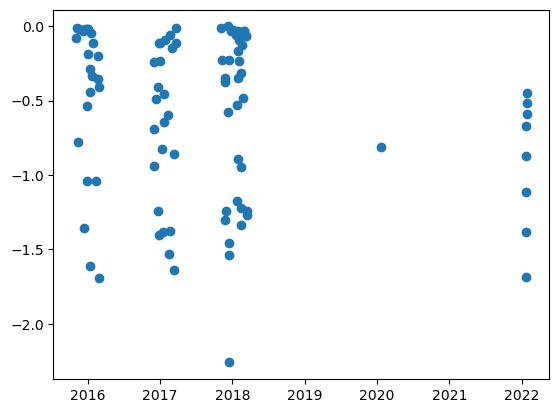

In [800]:
# Временное распределение данных переносы/ветровая нагрузка
plt.scatter(W.time_6, W.flow_W/10**6)
# plt.scatter(W.time_6, W.tau_x_rot)

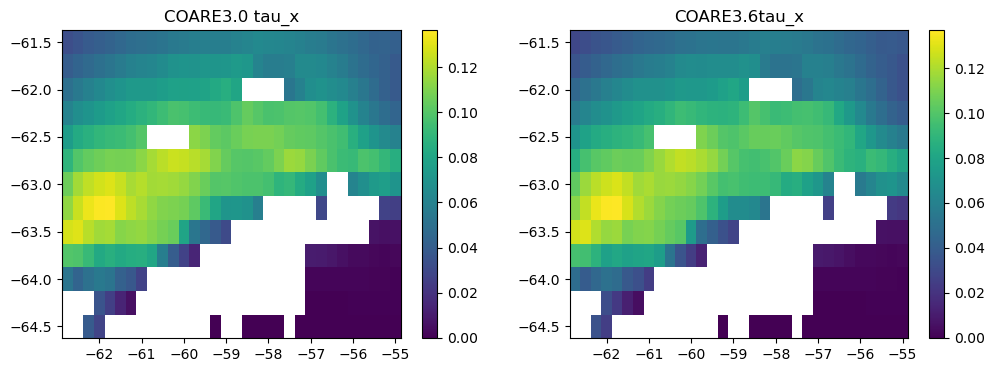

In [840]:
year = '2015'

time = 1008072.0
val1 = 'tau_x'
val2 = 'tau_x'


m = pd.read_csv(f'/Users/ilyadrozd/Desktop/IO/meteo/meteo_{year}.csv', sep=' ', header=None, 
                    names=['datetime', 'lat','lon','u10', 'v10', 'sst', 't2m', 'd2m', 'msl', 'lhf', 'shf', 'srd', 'trd', 'lsm'])

# примерно вырезаем интересующий нас участок по широте и долготе
m = m.loc[(m['lat']>-64.75)&(m['lat']<-61.25)]
m = m.loc[(m['lon']>-63)&(m['lon']<-54.75)]

lat = np.arange(m.lat.max(), m.lat.min()-0.25, -0.25)
lon = np.arange(m.lon.min(), m.lon.max()+0.25, 0.25)


fluxes = pd.read_csv(f'/Users/ilyadrozd/Desktop/IO/meteo/fluxes_coare3p0_{year}.csv', sep=' ', header=None, skipinitialspace=True,
                    names=['time', 'lat','lon','LE', 'H', 'tau_x', 'tau_y'])

# примерно вырезаем интересующий нас участок по широте и долготе
fluxes = fluxes.loc[m.index]

# убираем данные над сушей
fluxes.loc[m['lsm']>0.285, ['LE', 'H', 'tau_x', 'tau_y']] = np.nan




data = fluxes.loc[fluxes['time']==time][val1]
data = data.values.reshape(len(lat), len(lon))

plt.figure(figsize=(12,4))

ax1 = plt.subplot(121)
ax1.set_title(f'COARE3.0 {val1}')
map1 = ax1.pcolormesh(lon, lat, data) #pcolormesh contourf
plt.colorbar(map1)




fluxes = pd.read_csv(f'/Users/ilyadrozd/Desktop/IO/meteo/fluxes_coare3p6_{year}.csv', sep=' ', header=None, skipinitialspace=True,
                    names=['time', 'lat','lon','LE', 'H', 'tau_x', 'tau_y'])

# примерно вырезаем интересующий нас участок по широте и долготе
fluxes = fluxes.loc[m.index]

# убираем данные над сушей
fluxes.loc[m['lsm']>0.285, ['LE', 'H', 'tau_x', 'tau_y']] = np.nan

data = fluxes.loc[fluxes['time']==time][val2]
data = data.values.reshape(len(lat), len(lon))

ax2 = plt.subplot(122)
ax2.set_title(f'COARE3.6{val2}')
map2 = ax2.pcolormesh(lon, lat, data) #pcolormesh contourf
plt.colorbar(map2)

### Рисуем переносы и ветер за те же числа и с теми же координатами

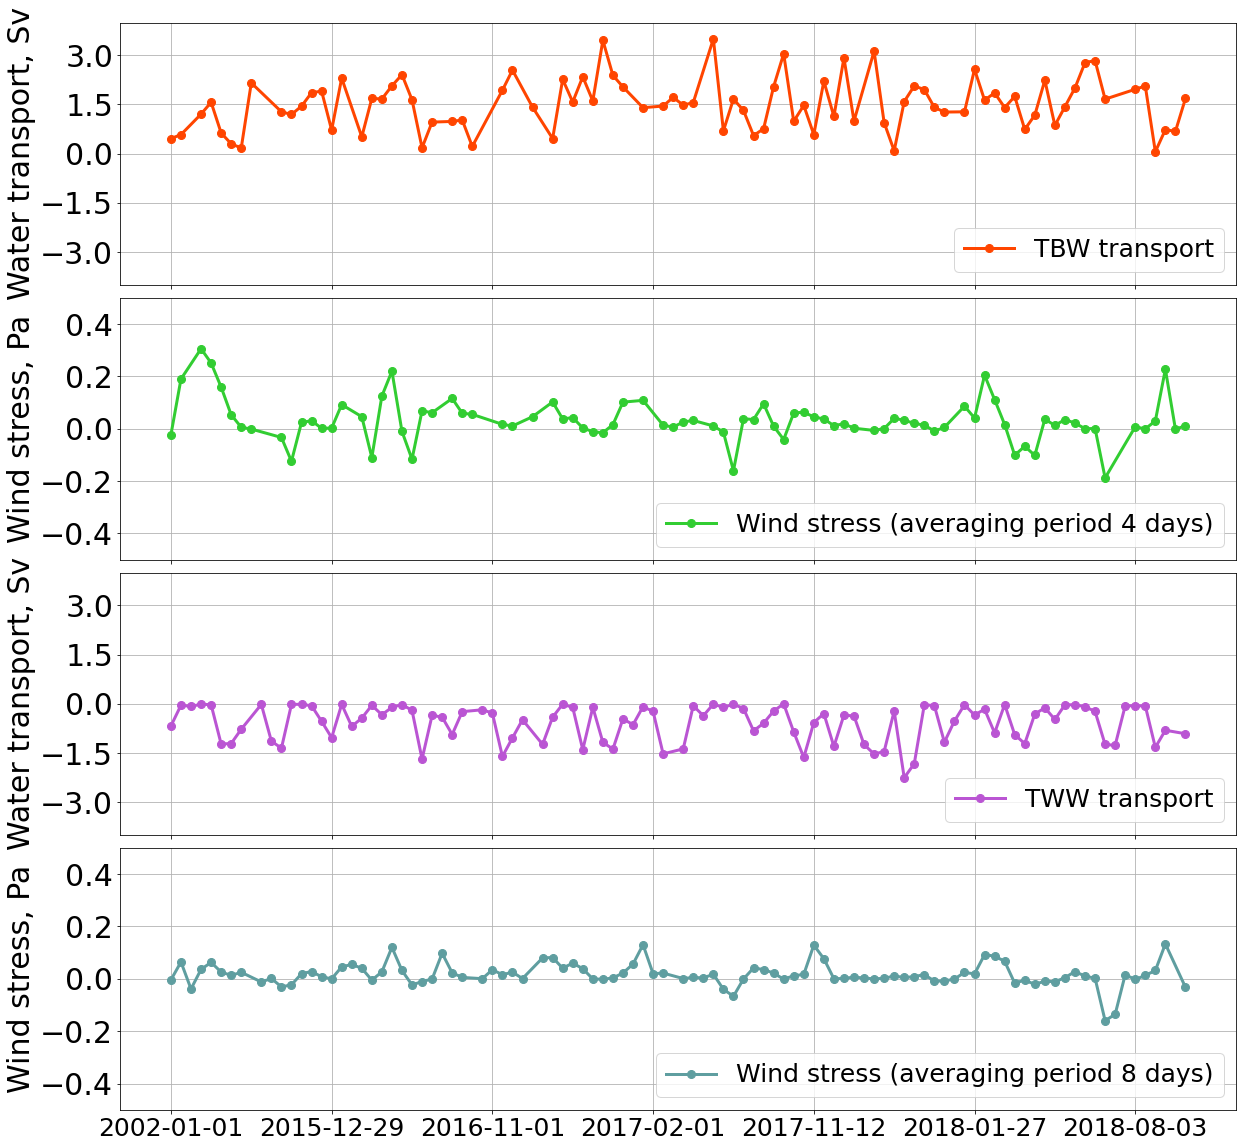

In [13]:

Bran = BW[['date','flow_B','B_u']].dropna() 
Bran['B_u'] *= abs(Bran['B_u'])*0.0015*1.2
Bran['flow_B'] /= 10**6

spec = gds.GridSpec(ncols=1, nrows=4, height_ratios=[1, 1, 1, 1], hspace=0.05)
spec1 = gds.GridSpec(ncols=2, nrows=1, width_ratios=[3, 1], wspace=0.05)

fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(spec[0])
B = ax1.plot(Bran.index, Bran['flow_B'], lw=3, markersize=8,  marker='o', label='TBW transport', c='orangered')
ax1.set_ylabel('Water transport, Sv', fontsize=30)
ax1.set_ylim([-4,4])
ax1.set_yticks(np.linspace(-3,3,5))
ax1.tick_params(axis='both', labelsize=30)
ax1.set_xticks(np.arange(0,len(BW),16))
ax1.set_xticklabels([])
ax1.legend(loc='lower right', fontsize=25)
ax1.grid()

# ax2 = plt.twinx()
ax2 = fig.add_subplot(spec[1])
WS_B = ax2.plot(Bran.index, Bran['B_u'], lw=3, markersize=8,  marker='o', label='Wind stress (averaging period 4 days)', c='limegreen')
ax2.set_ylabel(f'Wind stress, Pa', fontsize=30)
ax2.set_ylim([-0.5,0.5])
ax2.tick_params(axis='both', labelsize=30)
ax2.set_yticks(np.linspace(-0.4,0.4,5))
ax2.set_xticks(np.arange(0,len(BW),16))
ax2.set_xticklabels([])
ax2.legend(loc='lower right', fontsize=25)
ax2.grid()

Wed = BW[['date','flow_W','W_u']].dropna() 
Wed['W_u'] *= abs(Wed['W_u'])*0.0015*1.2
Wed['flow_W'] /= 10**6

ax3 = fig.add_subplot(spec[2])
W = ax3.plot(Wed.index, Wed['flow_W'], lw=3, markersize=8,  marker='o', label='TWW transport', c='mediumorchid')
ax3.set_xticks(np.arange(0,len(BW),16))
ax3.set_xticklabels([])
ax3.set_ylim([-4,4])
ax3.set_yticks(np.linspace(-3,3,5))
ax3.tick_params(axis='both', labelsize=30)
ax3.set_ylabel('Water transport, Sv', fontsize=30)
ax3.legend(loc='lower right', fontsize=25)
ax3.grid()


ax4 = fig.add_subplot(spec[3])
WS_W = ax4.plot(Wed.index, Wed['W_u'], lw=3, markersize=8, marker='o', label='Wind stress (averaging period 8 days)', c='cadetblue')
ax4.set_ylabel(f'Wind stress, Pa', fontsize=30)
ax4.set_ylim([-0.5,0.5])
ax4.tick_params(axis='both', labelsize=30)
ax4.set_yticks(np.linspace(-0.4,0.4,5))
ax4.set_xticks(np.arange(0,len(BW),16))
ax4.set_xticklabels(BW['date'][0:len(BW):16].dt.date, fontsize=25)
ax4.legend(loc='lower right', fontsize=25)
ax4.grid()

#ax5 = fig.add_subplot(spec1[1])


In [797]:
for sd in B_r[:,0]:
    sd=1 
B_r[:,0]

array([0., 0., 0., 0.])

In [9]:
window = 1
dig = 30    
    
B_r, B_mic =  np.zeros((4,31)), np.zeros((4,31))
W_r, W_mic =  np.zeros((4,31)), np.zeros((4,31))

for window in range(1, 32):

    meteo['tau_x_rot'] = np.nan
    meteo['tau_y_rot'] = np.nan

    for flow, time, lat, lon in zip(BW.flow_B, BW.time_6, BW.lat_B_025, BW.lon_B_025):

        filt = (meteo.datetime==time) & (meteo.lat==lat) & (meteo.lon==lon)
        row = meteo.loc[filt]

        # отбрасываем непересекающиеся данные (например переносы за 2002 год) 
        if row.empty:
            continue

        # отбрасываем случаи, когда нет данных по ветру (данные попали под маску) или по переносу
        if np.isnan(flow) | np.isnan(row.tau_x.values[0]):
    #         print(time, flow, row.tau_x.values[0])
            continue

        # считываем потоки импульса
        index = row.index[0]+1
        tau_x = meteo.tau_x.loc[index-window:index].mean()
        tau_y = meteo.tau_y.loc[index-window:index].mean()

        # поворачиваем потоки импульса вдоль пролива
        meteo.loc[filt, 'tau_x_rot'], meteo.loc[filt, 'tau_y_rot'] = rotated(dig, tau_x, tau_y)

    B = pd.merge(BW[['time_6','lat_B_025','lon_B_025','flow_B']], meteo[['datetime','lat','lon','tau_x_rot','tau_y_rot']],
                 left_on=['time_6','lat_B_025','lon_B_025'], right_on=['datetime','lat','lon'])

    B = B[(B.flow_B.notna())&(B.tau_x_rot.notna())]

    
    starts = pd.to_datetime(['2015-11-01 00:00:00','2016-11-01 00:00:00', '2017-11-01 00:00:00', '2022-01-20 00:00:00'])
    ends = pd.to_datetime(['2016-04-01 00:00:00','2017-04-01 00:00:00', '2018-04-01 00:00:00', '2022-01-30 00:00:00'])

    for j in zip(starts, ends):
        Bm = B.loc[(B.time_6>starts[j])&(B.time_6<ends[j])]
        B_r, B_mic =  compare(Bm.tau_x_rot, Bm.flow_B)


meteo['tau_x_rot'] = np.nan
meteo['tau_y_rot'] = np.nan

for flow, time, lat, lon in zip(BW.flow_W, BW.time_6, BW.lat_W_025, BW.lon_W_025):
    
    filt = (meteo.datetime==time) & (meteo.lat==lat) & (meteo.lon==lon)
    row = meteo.loc[filt]
    
    # отбрасываем непересекающиеся данные (например переносы за 2002 год) 
    if row.empty:
        continue
    
    # отбрасываем случаи, когда нет данных по ветру (данные попали под маску) или по переносу
    if np.isnan(flow) | np.isnan(row.tau_x.values[0]):
#         print(time, flow, row.tau_x.values[0])
        continue
    
    # считываем потоки импульса
    index = row.index[0]+1
    tau_x = meteo.tau_x.loc[index-window:index].mean()
    tau_y = meteo.tau_y.loc[index-window:index].mean()
    
    # поворачиваем потоки импульса вдоль пролива
    meteo.loc[filt, 'tau_x_rot'], meteo.loc[filt, 'tau_y_rot'] = rotated(dig, tau_x, tau_y)

W = pd.merge(BW[['time_6','lat_W_025','lon_W_025','flow_W']], meteo[['datetime','lat','lon','tau_x_rot','tau_y_rot']],
             left_on=['time_6','lat_W_025','lon_W_025'], right_on=['datetime','lat','lon'])
W = W[(W.flow_W.notna())&(W.tau_x_rot.notna())]



,date,flow_B,B_u
0,2002-01-01,0.457394,-0.000109
1,2002-04-01,0.579430,0.066560
3,2015-07-11,1.205218,0.009483
4,2015-07-12,1.567861,0.006744
5,2015-11-12,0.628798,-0.000572
...,...,...,...
97,2018-10-03,2.063602,0.036218
98,2018-12-02,0.057191,0.006449
99,2020-01-20,0.731065,0.019539
100,2020-02-26,0.678567,0.013598


In [7]:
R_B = np.zeros(31)
R_W = np.zeros(31)

for window in range(1, 32):

    W_u = np.full_like(BW['flow_W'],np.nan)
    W_v = np.full_like(BW['flow_W'],np.nan)
    B_u = np.full_like(BW['flow_B'],np.nan)
    B_v = np.full_like(BW['flow_B'],np.nan)

    for i in BW.index:

        if np.isnan(BW['flow_B'][i]) or (BW['date'][i].date() > date[-1]) :
            continue

        i_date = np.where(date == BW['date'][i].date())[0][0]+1

        i_lat = np.where(lat == BW['lat_B_0.25'][i])[0][0]
        i_lon = np.where(lon == BW['lon_B_0.25'][i])[0][0]

        u = data['u10'][i_date-window:i_date, 0, i_lat, i_lon]
        v = data['v10'][i_date-window:i_date, 0, i_lat, i_lon]

        u_rot, v_rot = rotated(dig, u, v)

        B_u[i] = u_rot.mean()
        B_v[i] = v_rot.mean()

    for i in BW.index:

        if np.isnan(BW['flow_W'][i]) or(BW['date'][i].date() > date[-1]):
            continue

        i_date = np.where(date == BW['date'][i].date())[0][0]+1
        i_lat = np.where(lat == BW['lat_W_0.25'][i])[0][0]
        i_lon = np.where(lon == BW['lon_W_0.25'][i])[0][0]
        
        u = data['u10'][i_date-window:i_date, 0, i_lat, i_lon]
        v = data['v10'][i_date-window:i_date, 0, i_lat, i_lon]

        u_rot, v_rot = rotated(dig, u, v)

        W_u[i] = u_rot.mean()
        W_v[i] = v_rot.mean()
    
    BW['W_u'] = W_u
    BW['W_v'] = W_v
    BW['B_u'] = B_u
    BW['B_v'] = W_v

    Bran = BW[['date','flow_B','B_u']].dropna() 
    Bran['B_u'] *= abs(Bran['B_u'])*0.0015*1.2
    Bran['flow_B'] /= 10**6

    Wed = BW[['date','flow_W','W_u']].dropna() 
    Wed['W_u'] *= abs(Wed['W_u'])*0.0015*1.2
    Wed['flow_W'] /= 10**6
    
    
    R_B[window-1] = np.corrcoef(Bran['B_u'], Bran['flow_B'])[0,1]
    R_W[window-1] = np.corrcoef(Wed['W_u'], Wed['flow_W'])[0,1]
    

In [553]:
np.corrcoef(Bran['B_u'], Bran['flow_B'])[0,1]

-0.1681634515135649

In [557]:
np.corrcoef(Wed['W_u'], Wed['flow_W'])[0,1]

0.1690856886821579

In [487]:
R_B

array([-0.073876  , -0.13036193, -0.16623919, -0.16816345, -0.16663841,
       -0.10875973, -0.05612236, -0.05680575, -0.03798984, -0.03815222,
       -0.02406692, -0.03904276, -0.04605749, -0.06831766, -0.10622006,
       -0.1196796 , -0.13753107, -0.14439667, -0.15876208, -0.17876843,
       -0.17147023, -0.15870374, -0.14414923, -0.13399289, -0.12425145,
       -0.10200583, -0.07647809, -0.04643149, -0.03628487, -0.03522303,
       -0.04013823])

In [488]:
R_W

array([-0.07044524,  0.00943538,  0.02723604,  0.08168566,  0.11615903,
        0.14904635,  0.13935707,  0.16908569,  0.16258949,  0.13937777,
        0.09318723,  0.06545756,  0.07212887,  0.07236147,  0.07149069,
        0.05559958,  0.02440914,  0.01543277,  0.02016192,  0.00739378,
       -0.00382471, -0.01386078, -0.03852658, -0.03817406, -0.03655888,
       -0.02729854, -0.02829519, -0.01925183, -0.00539023,  0.01272345,
        0.04878195])

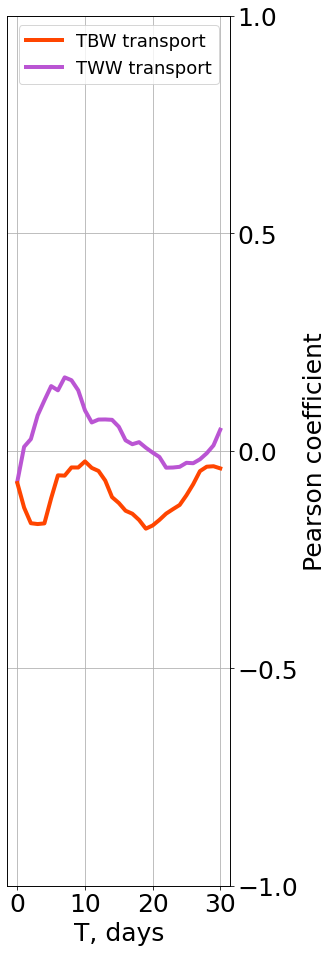

In [10]:
fig1 = plt.figure(figsize=(4, 16))
ax1 = plt.axes()
ax2 = plt.twinx()

ax1.grid()
ax1.set_ylim([-1,1])
ax1.set_yticks(np.linspace(-1, 1, 5))
ax1.set_xticks(np.linspace(0, 30, 4))

ax2.set_ylim([-1,1])
ax2.set_yticks(np.linspace(-1, 1, 5))

#ax1.tick_params(axis='y', right=True, left=False, labelleft=False, labelright=True, labelsize=30)
ax1.tick_params(axis='y', left=False, labelleft=False)

ax2.tick_params(axis='y', labelsize=25)
ax2.set_ylabel('Pearson coefficient', fontsize=25, labelpad=5)

ax1.tick_params(axis='x', labelsize=25)
ax1.set_xlabel('T, days', fontsize=25, labelpad=5)
W, = ax1.plot(R_W, lw=4, ls='-', c='mediumorchid')
B, = ax1.plot(R_B, lw=4, ls='-', c='orangered')
ax1.legend([B,W],['TBW transport','TWW transport'], fontsize=18, loc='upper center')

In [ ]:
days=31
R_u = np.zeros(days)
B_zone = ['Western','Middle','Eastern']
W_zone = ['Western','Middle-west','Middle-east','Eastern']
fig1 = plt.figure(figsize=(5, 10))
ax1 = plt.axes()
ax2 = plt.twinx()
for zone in np.unique(Brans['Zone']):
    Data = Brans.loc[Brans['Zone']==zone]    
    for d in range(days):
        mean_wind = list(map(lambda x: Wind['u_rot'].loc[(Wind['date']<= x)&(Wind['date']>= x-pd.to_timedelta(d, unit='day'))].mean(), Data['date']))
        R_u[d] = np.corrcoef(mean_wind, Data['Bransfield positive flow rate'])[0,1]
        
    B_s, = ax1.plot(R_u, lw=1.5, ls=':', c='gray')
    #, label=f'{B_zone[int(zone)-1]} Bransfield'
    
Data = Brans
for d in range(days):
    mean_wind = list(map(lambda x: Wind['u_rot'].loc[(Wind['date']<= x)&(Wind['date']>= x-pd.to_timedelta(d, unit='day'))].mean(), Data['date']))
    R_u[d] = np.corrcoef(mean_wind, Data['Bransfield positive flow rate'])[0,1]

B, = ax1.plot(R_u, label=f'Bransfield Total', lw=3, ls='-', c='orangered')
 
for zone in np.unique(Wedd['Zone']):
    Data = Wedd.loc[Wedd['Zone']==zone]
    for d in range(days):
        mean_wind = list(map(lambda x: Wind['u_rot'].loc[(Wind['date']<= x)&(Wind['date']>= x-pd.to_timedelta(d, unit='day'))].mean(), Data['date']))
        R_u[d] = np.corrcoef(mean_wind, Data['Weddell negative flow rate'])[0,1]
    
    W_s, = ax1.plot(R_u, lw=1.5, ls=':', c='gray')
    #, label=f'{W_zone[zone-1]} Weddell'
    
Data = Wedd
for d in range(days):
    mean_wind = list(map(lambda x: Wind['u_rot'].loc[(Wind['date']<= x)&(Wind['date']>= x-pd.to_timedelta(d, unit='day'))].mean(), Data['date']))
    R_u[d] = np.corrcoef(mean_wind, Data['Weddell negative flow rate'])[0,1]

W, = ax1.plot(R_u, label=f'Weddell Total', lw=3, ls='-', c='cadetblue')   

#ax1.legend([B_s, B, W_s, W],['Bransfield polygons','Bransfield Total','Weddell polygons','Weddell Total'], fontsize=15, loc='upper right')
ax1.grid()
ax1.set_ylim([-1,1])
ax1.set_yticks(np.linspace(-1, 1, 5))
ax1.set_xticks(np.linspace(0, 30, 4))

ax2.set_ylim([-1,1])
ax2.set_yticks(np.linspace(-1, 1, 5))

#ax1.tick_params(axis='y', right=True, left=False, labelleft=False, labelright=True, labelsize=30)
ax1.tick_params(axis='y', left=False, labelleft=False)

ax2.tick_params(axis='y', labelsize=35)
ax2.set_ylabel('Pearson coefficient', fontsize=40, labelpad=10)

ax1.tick_params(axis='x', labelsize=35)
ax1.set_xlabel('T, days', fontsize=40, labelpad=10)
ax1.legend([B,W],['TBW transport','TWW transport'], fontsize=18, loc='upper center')
margins = {
    "left"   : 0.010,
    "bottom" : 0.130,
    "right"  : 0.630,
    "top"    : 0.980    
    }
fig1.subplots_adjust(**margins)
plt.savefig(r'C:/Users/user/Desktop/Wind_corr_Bransfield.png', dpi=400)

In [ ]:
Q_Brans = Brans['Bransfield positive flow rate'].values
lat_Brans = Brans['Latitude '].values
lon_Brans = Brans['Longitude'].values
Q_Wedd = Wedd['Weddell negative flow rate'].values
lat_Wedd = Wedd['Latitude'].values
lon_Wedd = Wedd['Longitude'].values

Skittels(np.r_[lon_Brans,lon_Wedd]+360, np.r_[lat_Brans,lat_Wedd], np.r_[Q_Brans,Q_Wedd])

## Строим картинку с корреляцией ветра и потоков в проливе Брансфилд

### Считываем данные по Брансфилду, Ведделлу, файл с датой разрезов, и данные о ветре

In [3]:
dir = r'C:/Users/user/Desktop/IO/AMK_87/Bransfield_from-Gordey/Илье/'

# читаем df и выкидываем все лишнее
Brans=pd.read_csv(dir+'Q Bransfield section + meta.csv', sep='\t')
#Brans.drop(['Sample ID:INTEGER','yyyy-mm-ddThh:mm:ss.sss','Bransfield positive flow rate.1', 'Type', 'Station', 'Section Distance [km]'], axis=1, inplace=True)
#Brans['Bransfield positive flow rate']=Brans['Bransfield positive flow rate']/10**6 #переводим в Свердрупы

# читаем df и выкидываем все лишнее
Wedd = pd.read_csv(dir+'Weddell 2 + meta.csv', sep='\t')
#Wedd.drop(['Sample ID:INTEGER','yyyy-mm-ddThh:mm:ss.sss','Weddell negative flow rate.1', 'Type', 'Station', 'Section Distance [km]'], axis=1, inplace=True)
#Wedd['Weddell negative flow rate'] = -Wedd['Weddell negative flow rate']/10**6 #переводим в Свердрупы

# читаем df и выкидываем все, кроме даты и названия разреза 
Flow_all=pd.read_csv(dir+'Q Bransfield-Weddell 2015-2022 last.csv', sep=';')
Flow_all.drop(Flow_all.columns.drop(['Section','date']), axis=1, inplace=True)
# в названиях разрезов убираем пометку _filtered
for section in Flow_all['Section'].values:
    if section[-9:]=='_filtered':
        print(section)
        Flow_all['Section'].loc[Flow_all['Section']==section] = section[:-9]

Wind = pd.read_csv(dir+'Bransfield_mean_wind.txt', sep=' ') #читаем df по ветру
Wind.drop('time', axis=1, inplace=True)
Wind['date'] = pd.to_datetime(Wind['date']) #переводим время в datetime формат


AI52tr4_5_filtered
AI52tr5_2_filtered
AI52tr6_5_filtered
AI52tr7_2_filtered
AI52tr8_2_filtered
AI52tr9_2_filtered
AI52tr10_2_filtered
AI54tr1_4_filtered
AI54tr2_2_filtered
AI54tr3_2_filtered
AI54tr3_3_filtered
AI54tr3_4_filtered
AI54tr4_4_filtered
AI54tr4_5_filtered
AI54tr4_6_filtered
AI54tr5_2_filtered


### Присоединяем по названиям разрезов к данным по Брансфилду и Ведделлу даты

In [4]:
Brans = Brans.merge(Flow_all, how='left', left_on='Cruise', right_on='Section' ).drop('Section', axis=1) #соединяем дата фреймы и убираем дублирующуюся колонку с названием разреза 
Brans['date'] = pd.to_datetime(Brans['date']) #переводим время в datetime формат
Brans = Brans.sort_values('date', kind='mergesort') # делаем сортировку df по времени

Wedd = Wedd.merge(Flow_all, how='left', left_on='Cruise', right_on='Section' ).drop('Section', axis=1) #соединяем дата фреймы и убираем дублирующуюся колонку с названием разреза 
Wedd['date'] = pd.to_datetime(Wedd['date']) #переводим время в datetime формат
Wedd = Wedd.sort_values('date', kind='mergesort') # делаем сортировку df по времени

### Строим получившиеся потоки по Брансфилду и Ведделлу

In [4]:
# функция для быстрой отрисовки
def Skittels(lon, lat, q):

    #линии сетки по х и у
    y_grid = np.arange(np.floor(lat.min()),np.ceil(lat.max()), 0.5)
    x_grid = np.arange(np.floor(lon.min()),np.ceil(lon.max()), 0.5)

    #поля по х и у
    lon_marg=(lon.max()-lon.min())*0.1
    lat_marg=(lat.max()-lat.min())*0.1

    
    plt.figure(figsize=(10, 10))
    #projection = ccrs.Orthographic(central_longitude=300.0, central_latitude=-62.0)
    projection = ccrs.Miller()
    #projection = ccrs.PlateCarree()
    #projection = ccrs.Mercator()
    #projection = ccrs.InterruptedGoodeHomolosine()

    ax1 = plt.axes(projection=projection)
    #ax1.stock_img()
    ax1.coastlines('10m')
    ax1.gridlines(draw_labels=True, ylocs=y_grid, xlocs=x_grid-360, x_inline=False, y_inline=False)
    ax1.set_extent([lon.min()-lon_marg, lon.max()+lon_marg, lat.min()-lat_marg, lat.max()+lat_marg])
    #ax1.plot(coord[:, 0], coord[:, 1], transform=ccrs.PlateCarree(), c='r')
    scatter = ax1.scatter(lon, lat, c=q, cmap = 'jet', transform=ccrs.PlateCarree())
    plt.colorbar(scatter, location = 'bottom', pad=0.01, label='Crazy fLuXeS, Sv')
    ax1.set_title('Skittels in Bransfield')
    plt.show()
    plt.close()


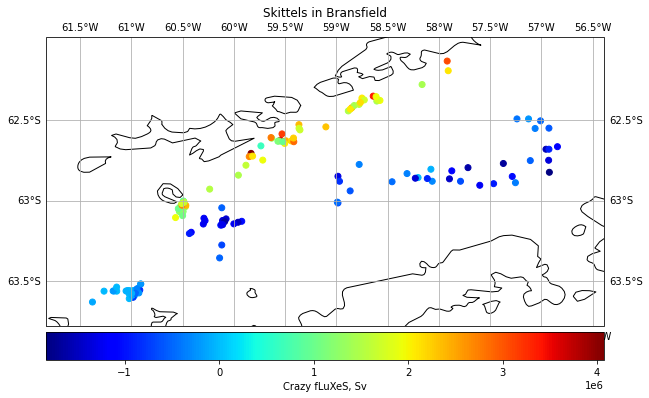

In [6]:
Q_Brans = Brans['Bransfield positive flow rate'].values
lat_Brans = Brans['Latitude '].values
lon_Brans = Brans['Longitude'].values
Q_Wedd = Wedd['Weddell negative flow rate'].values
lat_Wedd = Wedd['Latitude'].values
lon_Wedd = Wedd['Longitude'].values

Skittels(np.r_[lon_Brans,lon_Wedd]+360, np.r_[lat_Brans,lat_Wedd], np.r_[Q_Brans,Q_Wedd])

### Оставляем только те данные по потокам, за которые есть ветер

In [7]:
Brans = Brans.loc[(Brans['date']<=Wind['date'].values[-1]) & (Brans['date']>=Wind['date'].values[0])] #обрезаем разрезы для которых нет данных по ветру
Wedd = Wedd.loc[(Wedd['date']<=Wind['date'].values[-1]) & (Wedd['date']>=Wind['date'].values[0])] #обрезаем разрезы для которых нет данных по ветру


### Считаем и отрисовываем корреляции с ветром при разном периоде осреднения для потоков по всем данным и отдельно по полигонам

In [ ]:
fig1 = plt.figure(figsize=(5, 10))
ax1 = plt.axes()
ax2 = plt.twinx()

ax1.grid()
ax1.set_ylim([-1,1])
ax1.set_yticks(np.linspace(-1, 1, 5))
ax1.set_xticks(np.linspace(0, 30, 4))

ax2.set_ylim([-1,1])
ax2.set_yticks(np.linspace(-1, 1, 5))

#ax1.tick_params(axis='y', right=True, left=False, labelleft=False, labelright=True, labelsize=30)
ax1.tick_params(axis='y', left=False, labelleft=False)

ax2.tick_params(axis='y', labelsize=35)
ax2.set_ylabel('Pearson coefficient', fontsize=40, labelpad=10)

ax1.tick_params(axis='x', labelsize=35)
ax1.set_xlabel('T, days', fontsize=40, labelpad=10)
ax1.legend([B,W],['TBW transport','TWW transport'], fontsize=18, loc='upper center')

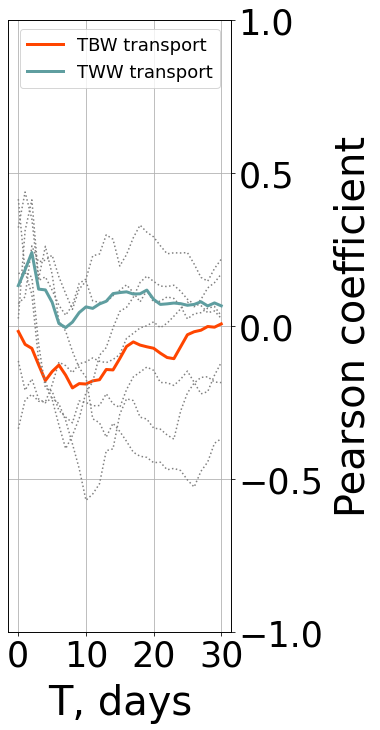

In [8]:
days=31
R_u = np.zeros(days)
B_zone = ['Western','Middle','Eastern']
W_zone = ['Western','Middle-west','Middle-east','Eastern']
fig1 = plt.figure(figsize=(5, 10))
ax1 = plt.axes()
ax2 = plt.twinx()
for zone in np.unique(Brans['Zone']):
    Data = Brans.loc[Brans['Zone']==zone]    
    for d in range(days):
        mean_wind = list(map(lambda x: Wind['u_rot'].loc[(Wind['date']<= x)&(Wind['date']>= x-pd.to_timedelta(d, unit='day'))].mean(), Data['date']))
        R_u[d] = np.corrcoef(mean_wind, Data['Bransfield positive flow rate'])[0,1]
        
    B_s, = ax1.plot(R_u, lw=1.5, ls=':', c='gray')
    #, label=f'{B_zone[int(zone)-1]} Bransfield'
    
Data = Brans
for d in range(days):
    mean_wind = list(map(lambda x: Wind['u_rot'].loc[(Wind['date']<= x)&(Wind['date']>= x-pd.to_timedelta(d, unit='day'))].mean(), Data['date']))
    R_u[d] = np.corrcoef(mean_wind, Data['Bransfield positive flow rate'])[0,1]

B, = ax1.plot(R_u, label=f'Bransfield Total', lw=3, ls='-', c='orangered')
 
for zone in np.unique(Wedd['Zone']):
    Data = Wedd.loc[Wedd['Zone']==zone]
    for d in range(days):
        mean_wind = list(map(lambda x: Wind['u_rot'].loc[(Wind['date']<= x)&(Wind['date']>= x-pd.to_timedelta(d, unit='day'))].mean(), Data['date']))
        R_u[d] = np.corrcoef(mean_wind, Data['Weddell negative flow rate'])[0,1]
    
    W_s, = ax1.plot(R_u, lw=1.5, ls=':', c='gray')
    #, label=f'{W_zone[zone-1]} Weddell'
    
Data = Wedd
for d in range(days):
    mean_wind = list(map(lambda x: Wind['u_rot'].loc[(Wind['date']<= x)&(Wind['date']>= x-pd.to_timedelta(d, unit='day'))].mean(), Data['date']))
    R_u[d] = np.corrcoef(mean_wind, Data['Weddell negative flow rate'])[0,1]

W, = ax1.plot(R_u, label=f'Weddell Total', lw=3, ls='-', c='cadetblue')   

#ax1.legend([B_s, B, W_s, W],['Bransfield polygons','Bransfield Total','Weddell polygons','Weddell Total'], fontsize=15, loc='upper right')
ax1.grid()
ax1.set_ylim([-1,1])
ax1.set_yticks(np.linspace(-1, 1, 5))
ax1.set_xticks(np.linspace(0, 30, 4))

ax2.set_ylim([-1,1])
ax2.set_yticks(np.linspace(-1, 1, 5))

#ax1.tick_params(axis='y', right=True, left=False, labelleft=False, labelright=True, labelsize=30)
ax1.tick_params(axis='y', left=False, labelleft=False)

ax2.tick_params(axis='y', labelsize=35)
ax2.set_ylabel('Pearson coefficient', fontsize=40, labelpad=10)

ax1.tick_params(axis='x', labelsize=35)
ax1.set_xlabel('T, days', fontsize=40, labelpad=10)
ax1.legend([B,W],['TBW transport','TWW transport'], fontsize=18, loc='upper center')
margins = {
    "left"   : 0.010,
    "bottom" : 0.130,
    "right"  : 0.630,
    "top"    : 0.980    
    }
fig1.subplots_adjust(**margins)
plt.savefig(r'C:/Users/user/Desktop/Wind_corr_Bransfield.png', dpi=400)

## Строим картинку с сезонной изменчивостью потоков, ветра, сплоченностью льда и SST в проливе Брансфилд

### Считываем данные о среднемесячных потоках в Ведделле и Брансфилде, поверхностой температуре, сплоченности льда и ветре

In [31]:
ice = nc.Dataset(r'C:\Users\user\Desktop\IO\AMK_87\ice\monthly_mean_ice.nc','r')

SST = nc.Dataset(r'C:\Users\user\Desktop\IO\AMK_87\SST\monthly_mean_SST.nc','r')

Wedd = pd.read_csv(r'C:\Users\user\Desktop\weddell seasonal.txt', sep='\t')

Brans = pd.read_csv(r'C:\Users\user\Desktop\brans seasonal.txt', sep='\t')

Wind = pd.read_csv(r'C:\Users\user\Desktop\IO\AMK_87\Bransfield_mean_wind.txt', sep=' ') #читаем df по ветру
Wind.drop('time', axis=1, inplace=True)
Wind['date'] = pd.to_datetime(Wind['date']) #переводим время в datetime формат
#Wind

### Вырезаем данные по льду и SST по проливу Брансфилд и осредняем их по площади

In [154]:
# функция для создания прямоугольного полигона
def poly(dig, a, b, A, mer_len, par_len):
    rad = np.radians(dig) #угол наклона полигона относительно параллели в радианах
    x_rot=np.array([ np.cos(rad), np.sin(rad)]) #повернутый x-базис вектор
    y_rot=np.array([ np.cos(rad+np.pi/2), np.sin(rad+np.pi/2)]) #повернутый y-базис вектор

    B = 0*x_rot-b*y_rot
    C = a*x_rot-b*y_rot
    D = a*x_rot+0*y_rot
    
    B = [A[0]+B[0]*360/par_len, A[1]+B[1]*360/mer_len]
    C = [A[0]+C[0]*360/par_len, A[1]+C[1]*360/mer_len]
    D = [A[0]+D[0]*360/par_len, A[1]+D[1]*360/mer_len]
    
    polygon = path.Path([A, B, C, D]) #полигон интересующей нас области (Брансфилд)
    return polygon, np.array([A, B, C, D, A])

In [155]:
# функция для вырезания ncdf данных по заданному полигону
def masked(lat, lon, ice, polygon):
    data_shape = ice.shape
    xx,yy = np.meshgrid(lon, lat) #получаем массивы широт и долгот каждого узла сетки
    coord = np.hstack((xx.flatten()[:,np.newaxis], yy.flatten()[:,np.newaxis])) #получаем массив координат всех узлов сетки
    mask = np.logical_not(polygon.contains_points(coord)) #маска входящих в полигон значений
    mask = [mask.reshape(data_shape[1],data_shape[2])]*data_shape[0]
    ice_masked = np.ma.masked_array(ice, mask)
    return ice_masked

In [34]:
poly_Brans, coord_Brans = poly(dig = 30, a = 350, b = 135, A = [-62.5,-63.3], mer_len = 40008.55, par_len = 20088)

lat = ice['lat'][:]
lon = ice['lon'][:]
ice = ice['mean_sea_ice'][::]
SST = SST['mean_SST'][::]

ice_Brans = masked(lat, lon, ice, poly_Brans) #вырезаем данные по заданному полигону
SST_Brans = masked(lat, lon, SST, poly_Brans) #вырезаем данные по заданному полигону

ice_Brans = ice_Brans[::].mean(axis=(1,2))
SST_Brans = SST_Brans[::].mean(axis=(1,2))-273.15

### Группируем по месяцам данные о ветре и осредняем их

In [35]:
Wind['month'] = Wind['date'].dt.month
wind_Brans = Wind.groupby('month').mean()['u_rot']

### Визуализируем среднемесячные ряды данных

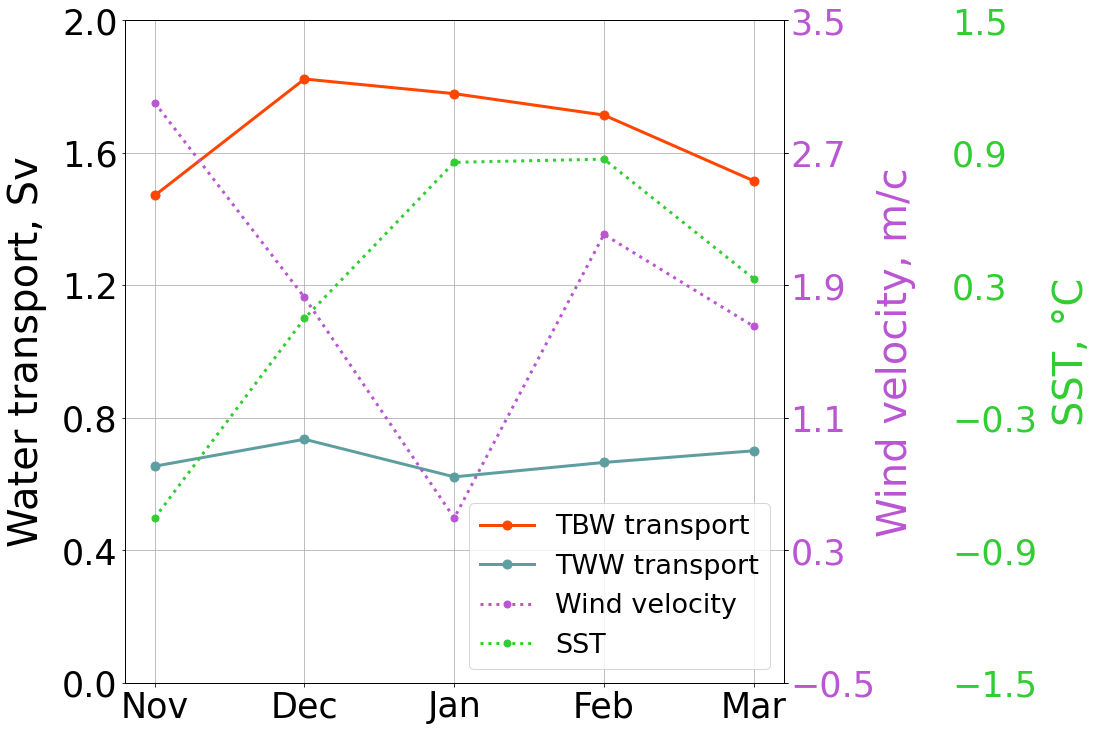

In [48]:
fig1 = plt.figure(figsize=(15, 10))
ax1 = plt.axes()
brans, = ax1.plot(Brans['Bransfield flow rate']/10**6, marker='o', markersize=9, lw=3, c='orangered')
wedd, = ax1.plot(Wedd['Weddell negative flow rate']/10**6, marker='o', markersize=9, lw=3, c='cadetblue')
#ax1.plot(np.r_[ice_Brans[10:], ice_Brans[:3]], label='Ice fraction')

ax1.set_xticks(np.arange(5))
ax1.tick_params(axis='both', labelsize=35)
ax1.set_xticklabels(labels=['Nov','Dec','Jan','Feb','Mar'], size=35)
ax1.set_ylim([0,2])
ax1.set_yticks(np.linspace(0,2,6))
#ax1.set_xlabel('$Data,$ $months$', fontsize=30)
ax1.set_ylabel('Water transport, Sv', fontsize=40, labelpad=15)

ax2 = plt.twinx()
ax2.set_ylim([-0.5,3.5])
ax2.set_yticks(np.linspace(-0.5,3.5,6))
ax2.set_ylabel('Wind velocity, m/c', fontsize=40, color='mediumorchid', labelpad=0)
ax2.tick_params(axis='y', right=True, left=False, labelleft=False, labelright=True, labelsize=35, labelcolor='mediumorchid')
ws, = ax2.plot(np.r_[wind_Brans[10:], wind_Brans[:3]], marker='o', markersize=7, ls=':', lw=3, c='mediumorchid')

ax3 = plt.twinx(ax=ax1)
ax3.set_ylim([-1.5,1.5])
ax3.set_yticks(np.linspace(-1.5,1.5,6))
ax3.set_ylabel('SST, °C', fontsize=40, color='limegreen',labelpad=15)
ax3.tick_params(axis='y', right=True, left=False, labelleft=False, labelright=True, labelsize=35, pad=165, labelcolor='limegreen')
sst, = ax3.plot(np.r_[SST_Brans[10:], SST_Brans[:3]], marker='o', markersize=7, ls=':', lw=3, c='limegreen')
margins = {
    "left"   : 0.110,
    "bottom" : 0.060,
    "right"  : 0.720,
    "top"    : 0.980    
    }
fig1.subplots_adjust(**margins)
ax1.grid()
ax1.legend([brans, wedd, ws, sst],['TBW transport', 'TWW transport', 'Wind velocity', 'SST'], loc=4, fontsize=27)
plt.savefig(r'C:\Users\user\Desktop\seasons_Brans.png', dpi=400)


### Дальше более подробный анализ корреляций ветра и переноса в течении Ведделла

In [717]:
#Находим время максимального и минимального потока в каждом секторе
date_62_59_min = Wedd_62_59['date'].iloc[Wedd_62_59['Weddell flow rate'].argmin()]
date_62_59_max = Wedd_62_59['date'].iloc[Wedd_62_59['Weddell flow rate'].argmax()]

date_59_56_min = Wedd_59_56['date'].iloc[Wedd_59_56['Weddell flow rate'].argmin()]
date_59_56_max = Wedd_59_56['date'].iloc[Wedd_59_56['Weddell flow rate'].argmax()]

In [718]:
#Функция, считающая осредненный за указанное количество дней ветер до указанной даты
def mean_wind_before(date, d):
    return Wind['u_rot'].loc[(Wind['date'] <= date) & (Wind['date'] >= date-pd.to_timedelta(d, unit='day'))].mean()

In [719]:
#Считаем средний ветер для максимальных и минимальных потоков по секторам за период осреднения от 1 до 31 месяца
days=np.arange(31)

wind_62_59_max = list(map(lambda x: mean_wind_before(date_62_59_max, x), days)) 
wind_62_59_min = list(map(lambda x: mean_wind_before(date_62_59_min, x), days)) 

wind_59_56_max = list(map(lambda x: mean_wind_before(date_59_56_max, x), days)) 
wind_59_56_min = list(map(lambda x: mean_wind_before(date_59_56_min, x), days)) 

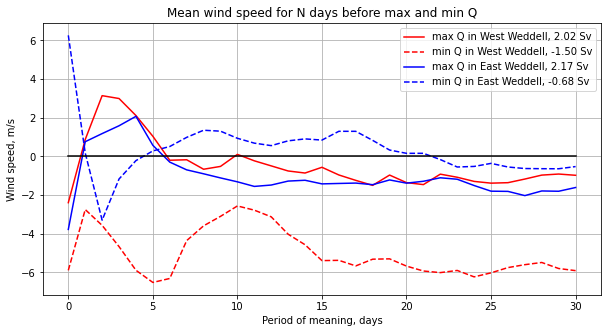

In [720]:
#визуализируем полученный результат
plt.figure(figsize=(10, 5))
plt.plot(wind_62_59_max, c='r', label='max Q in West Weddell, %.2f Sv' %(Wedd_62_59['Weddell flow rate'].max()))
plt.plot(wind_62_59_min, c='r', ls='--', label='min Q in West Weddell, %.2f Sv' % (Wedd_62_59['Weddell flow rate'].min()))
plt.plot(wind_59_56_max, c='b', label='max Q in East Weddell, %.2f Sv' %(Wedd_59_56['Weddell flow rate'].max()))
plt.plot(wind_59_56_min, c='b', ls='--', label='min Q in East Weddell, %.2f Sv' %(Wedd_59_56['Weddell flow rate'].min()))
plt.legend()
plt.grid()
plt.ylabel('Wind speed, m/s')
plt.xlabel('Period of meaning, days')
plt.title('Mean wind speed for N days before max and min Q')
plt.plot(np.zeros_like(wind_61_60_max), c='k')

In [730]:
Wind_max = Wind.loc[Wind['u_rot']>10]
Wind_min = Wind.loc[Wind['u_rot']<-10]

Flows_max = Wedd.loc[Wedd['Weddell flow rate']>1.75]
Flows_min = Wedd.loc[Wedd['Weddell flow rate']<0]

In [731]:
Wind_max.merge(Wedd, how='inner', on='date')

,date,u,v,u_rot,v_rot,Weddell negative flow rate,Cruise,Longitude [degrees East],Latitude [degrees North],Weddell positive flow rate,Weddell flow rate


In [732]:
Wind_min.merge(Wedd, how='inner', on='date')

,date,u,v,u_rot,v_rot,Weddell negative flow rate,Cruise,Longitude [degrees East],Latitude [degrees North],Weddell positive flow rate,Weddell flow rate
0,2017-09-11,12.508109,0.047244,-10.855963,-6.213140,-3.308718e+05,AI54tr2_2_filtered,299.194,-63.477,1426.852760,0.329445
1,2018-02-14,13.110372,-0.363979,-11.171926,-6.870401,-1.348269e+06,AI54tr9_4,302.264,-62.997,0.000000,1.348269
2,2018-02-14,13.110372,-0.363979,-11.171926,-6.870401,-4.132854e+05,AI54tr9_5,299.034,-63.569,1182.328498,0.412103
3,2018-02-14,13.110372,-0.363979,-11.171926,-6.870401,-1.922549e+06,ASV45tr10_3,299.081,-63.570,1226.053152,1.921323


In [733]:
Flows_min.merge(Wind, how='inner', on='date')

,Weddell negative flow rate,Cruise,Longitude [degrees East],Latitude [degrees North],Weddell positive flow rate,date,Weddell flow rate,u,v,u_rot,v_rot
0,-130081.62500,ASV40tr7_2,299.031,-63.569,1.659406e+05,2016-01-17,-0.035859,5.676701,2.272594,-6.052465,-0.870226
1,-131298.14063,AI50tr7_2,299.021,-63.580,2.119399e+05,2016-01-28,-0.080642,-2.521995,-1.052315,2.710269,0.349666
2,-293685.15625,ASV40tr6_4,302.663,-62.623,6.889950e+05,2016-04-01,-0.395310,6.573562,0.323066,-5.854405,-3.006998
3,-287895.93750,ASV43tr3_5,303.382,-62.482,7.332240e+05,2017-02-01,-0.445328,-2.857523,-2.204561,3.576968,-0.480444
4,-313356.65625,ASV43tr8_5,303.220,-62.576,9.896831e+05,2017-02-26,-0.676326,-7.226074,-0.008140,6.262034,3.605988
5,-145851.14063,AI52tr10_2_filtered,299.029,-63.582,1.951962e+05,2017-03-24,-0.049345,7.303423,2.022624,-7.336262,-1.900068
6,0.00000,ASV45tr4_2,299.341,-63.385,1.503914e+06,2017-10-12,-1.503914,7.280398,-0.816081,-5.896969,-4.346946
7,-139164.03125,ASV45tr10_4,299.051,-63.585,2.307714e+05,2018-02-19,-0.091607,2.098463,2.145113,-2.889879,0.808491
8,-271468.40625,ASV45tr11_3,299.003,-63.606,9.878675e+05,2018-02-27,-0.716399,2.662409,0.680218,-2.645823,-0.742119
9,-163143.34375,ASV45tr9_2,299.047,-63.571,3.461242e+05,2018-03-02,-0.182981,-10.055939,-0.147328,8.782363,4.900380


In [734]:
Flows_max.merge(Wind, how='inner', on='date')

,Weddell negative flow rate,Cruise,Longitude [degrees East],Latitude [degrees North],Weddell positive flow rate,date,Weddell flow rate,u,v,u_rot,v_rot
0,-1851095.750,ASV40tr4_2,299.826,-63.015,0.000000,2015-11-12,1.851096,9.423976,-0.958920,-7.681942,-5.542437
1,-2167551.250,AI50tr6_5,302.150,-62.964,1698.092173,2016-12-01,2.165853,3.024396,2.319937,-3.779172,0.496927
2,-1804442.875,ASV43tr3_1,299.024,-63.610,0.000000,2016-12-27,1.804443,-8.081185,-0.585055,7.291039,3.533920
3,-1949796.000,ASV43tr5_1,298.914,-63.718,0.000000,2017-01-17,1.949796,-1.673356,7.520721,-2.311192,7.349813
4,-1986809.000,ASV43tr7_3,300.294,-63.018,2722.156818,2017-02-14,1.984087,3.225664,-3.608792,-0.989111,-4.738138
5,-1772797.000,ASV45tr3_3,300.140,-63.079,0.000000,2017-11-28,1.772797,6.474786,-1.460417,-4.877120,-4.502151
6,-2026710.375,ASV45tr9_1,299.126,-63.572,7523.510667,2018-01-31,2.019187,-0.709076,6.018690,-2.395267,5.566876
7,-1922548.750,ASV45tr10_3,299.081,-63.570,1226.053152,2018-02-14,1.921323,13.110372,-0.363979,-11.171926,-6.870401


## Считаем для всех переносов средний за указанный период ветер

In [771]:
days=31
R2, R2_62_59, R2_59_56 = np.zeros(days), np.zeros(days), np.zeros(days)
for d in range(days):
    mean_wind = list(map(lambda x: Wind['u_rot'].loc[(Wind['date']<= x)&(Wind['date']>= x-pd.to_timedelta(d, unit='day'))].mean(), Wedd['date']))
    R2[d] = np.corrcoef(mean_wind, Wedd['Weddell flow rate'])[0,1]
    mean_wind_62_59 = list(map(lambda x: Wind['u_rot'].loc[(Wind['date']<= x)&(Wind['date']>= x-pd.to_timedelta(d, unit='day'))].mean(), Wedd_62_59['date']))
    R2_62_59[d] = np.corrcoef(mean_wind_62_59, Wedd_62_59['Weddell flow rate'])[0,1]
    mean_wind_59_56 = list(map(lambda x: Wind['u_rot'].loc[(Wind['date']<= x)&(Wind['date']>= x-pd.to_timedelta(d, unit='day'))].mean(), Wedd_59_56['date']))
    R2_59_56[d] = np.corrcoef(mean_wind_59_56, Wedd_59_56['Weddell flow rate'])[0,1]

Text(0.5, 1.0, 'Correlation between Q and WS for different averaging-period in Weddell')

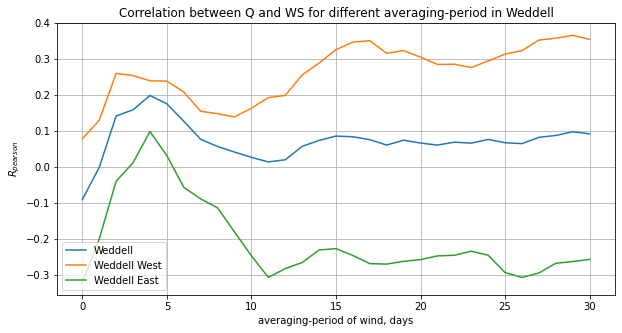

In [773]:
plt.figure(figsize=(10, 5))
plt.plot(R2, label='Weddell')
plt.plot(R2_62_59, label='Weddell West')
plt.plot(R2_59_56, label='Weddell East')
plt.legend()
plt.grid()
plt.ylabel('$R_{pearson}$')
plt.xlabel('averaging-period of wind, days')
plt.title('Correlation between Q and WS for different averaging-period in Weddell')

In [774]:
d=31
mean_wind = list(map(lambda x: Wind['u_rot'].loc[(Wind['date']<= x)&(Wind['date']>= x-pd.to_timedelta(d, unit='day'))].mean(), Wedd['date']))
mean_wind_62_59 = list(map(lambda x: Wind['u_rot'].loc[(Wind['date']<= x)&(Wind['date']>= x-pd.to_timedelta(d, unit='day'))].mean(), Wedd_62_59['date']))
mean_wind_59_56 = list(map(lambda x: Wind['u_rot'].loc[(Wind['date']<= x)&(Wind['date']>= x-pd.to_timedelta(d, unit='day'))].mean(), Wedd_59_56['date']))

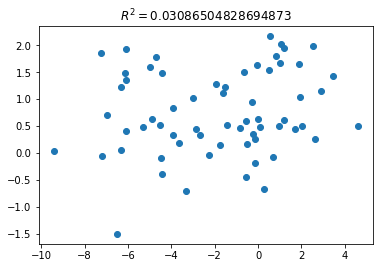

In [758]:
x = mean_wind
y = Wedd['Weddell flow rate']
plt.title(f'$R^2={np.corrcoef(x,y)[0,1]**2}$')
plt.scatter(x, y)

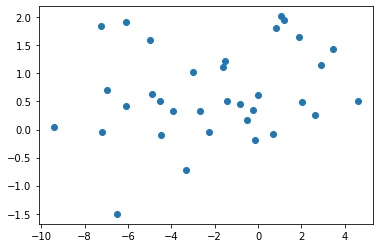

In [747]:
x = mean_wind_62_59
y = Wedd_62_59['Weddell flow rate']
plt.scatter(x, y)

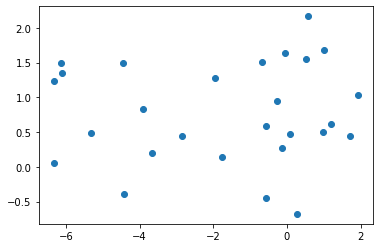

In [748]:
x = mean_wind_59_56
y = Wedd_59_56['Weddell flow rate']
plt.scatter(x, y)

## ОтрисовОчка

In [3]:
def Skittels(lon, lat, q):

    #линии сетки по х и у
    y_grid = np.arange(np.floor(lat.min()),np.ceil(lat.max()), 0.5)
    x_grid = np.arange(np.floor(lon.min()),np.ceil(lon.max()), 0.5)

    #поля по х и у
    lon_marg=(lon.max()-lon.min())*0.1
    lat_marg=(lat.max()-lat.min())*0.1

    
    plt.figure(figsize=(10, 10))
    #projection = ccrs.Orthographic(central_longitude=300.0, central_latitude=-62.0)
    projection = ccrs.Miller()
    #projection = ccrs.PlateCarree()
    #projection = ccrs.Mercator()
    #projection = ccrs.InterruptedGoodeHomolosine()

    ax1 = plt.axes(projection=projection)
    #ax1.stock_img()
    ax1.coastlines('10m')
    ax1.gridlines(draw_labels=True, ylocs=y_grid, xlocs=x_grid-360, x_inline=False, y_inline=False)
    ax1.set_extent([lon.min()-lon_marg, lon.max()+lon_marg, lat.min()-lat_marg, lat.max()+lat_marg])
    #ax1.plot(coord[:, 0], coord[:, 1], transform=ccrs.PlateCarree(), c='r')
    scatter = ax1.scatter(lon, lat, c=q, cmap = 'jet', transform=ccrs.PlateCarree())
    plt.colorbar(scatter, location = 'bottom', pad=0.01, label='Crazy fLuXeS, Sv')
    ax1.set_title('Skittels in Bransfield')
    plt.show()
    plt.close()
